# 🧪 Prétraitement, Modélisation & Évaluation

Dans cette section, nous passons à la phase pratique du projet avec quatre grandes étapes essentielles du **pipeline de deep learning** pour la classification d'images médicales :

1. 🎛️ **Prétraitement des images**  
   Les images sont redimensionnées, normalisées, et converties au bon format pour être compatibles avec notre modèle. Un pipeline de chargement efficace est mis en place à l’aide de `image_dataset_from_directory`.

2. 🧠 **Création du modèle**  
   Un réseau de neurones convolutionnels (CNN) est défini à l’aide de Keras. Il est adapté à la classification binaire : prédire si une radio thoracique correspond à un cas **NORMAL** ou de **PNEUMONIA**.

3. 🚀 **Entraînement du modèle**  
   Le modèle est entraîné sur les données d’apprentissage avec validation intermédiaire. Nous utilisons des callbacks pour surveiller les performances et éviter le surapprentissage.

4. 📈 **Évaluation des performances**  
   Une fois le modèle entraîné, il est évalué sur le jeu de test. Nous analysons sa performance à travers plusieurs métriques (accuracy, matrice de confusion, courbe ROC, etc.).

Cette étape est cruciale pour juger de la **capacité du modèle à généraliser** sur de nouvelles images, et à être potentiellement utilisé en contexte médical.

# Importation des librairies

In [31]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report, ConfusionMatrixDisplay

# Fixer la seed pour la reproductibilité
tf.random.set_seed(42)
np.random.seed(42)

## 📦 Chargement des jeux de données (train, validation, test)

À cette étape, nous utilisons la fonction `image_dataset_from_directory` de TensorFlow pour charger efficacement les images depuis les dossiers `train`, `val`, et `test`.  
Chaque image est convertie en **niveau de gris** (`grayscale`), redimensionnée en **224x224** pixels, et regroupée en **batches de 32** images pour faciliter l'entraînement du modèle.

Les labels sont chargés sous forme d'entiers (0 pour NORMAL, 1 pour PNEUMONIA), ce qui convient à une classification binaire.

Les trois datasets ainsi créés sont :
- `train_ds` : utilisé pour entraîner le modèle.
- `val_ds` : utilisé pour surveiller la performance sur des données jamais vues pendant l'entraînement.
- `test_ds` : réservé à l’évaluation finale du modèle, une fois l'entraînement terminé.

Ce chargement structuré garantit une bonne gestion de la mémoire et permet d’entraîner le modèle plus efficacement.

In [32]:
batch_size = 32
img_size = (224, 224)

train_dir = "chest_Xray/train"
val_dir = "chest_Xray/val"
test_dir = "chest_Xray/test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='int'
)

Found 4900 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.
Found 1050 files belonging to 2 classes.


## 🖼️ Visualisation d’un batch d’images

Avant d'entraîner notre modèle, il est essentiel de visualiser un échantillon des données pour vérifier que tout a été correctement chargé et prétraité.

Dans cette cellule, on récupère un **batch d’images** depuis le dataset d’entraînement (`train_ds`) et on affiche les **9 premières images**.  
Chaque image est affichée en **niveaux de gris** avec son **label** associé (`NORMAL` ou `PNEUMONIA`).

Cette visualisation rapide permet de :
- Vérifier que les images ont bien été converties en niveaux de gris.
- Confirmer que les dimensions correspondent à ce qu’on attend (`(224, 224, 1)`).
- S’assurer que les labels sont correctement associés aux images.

Cela constitue un bon point de départ pour s'assurer de la qualité des données avant l'entraînement.

Image 1 - Shape: (224, 224, 1)
Image 2 - Shape: (224, 224, 1)
Image 3 - Shape: (224, 224, 1)
Image 4 - Shape: (224, 224, 1)
Image 5 - Shape: (224, 224, 1)
Image 6 - Shape: (224, 224, 1)
Image 7 - Shape: (224, 224, 1)
Image 8 - Shape: (224, 224, 1)
Image 9 - Shape: (224, 224, 1)


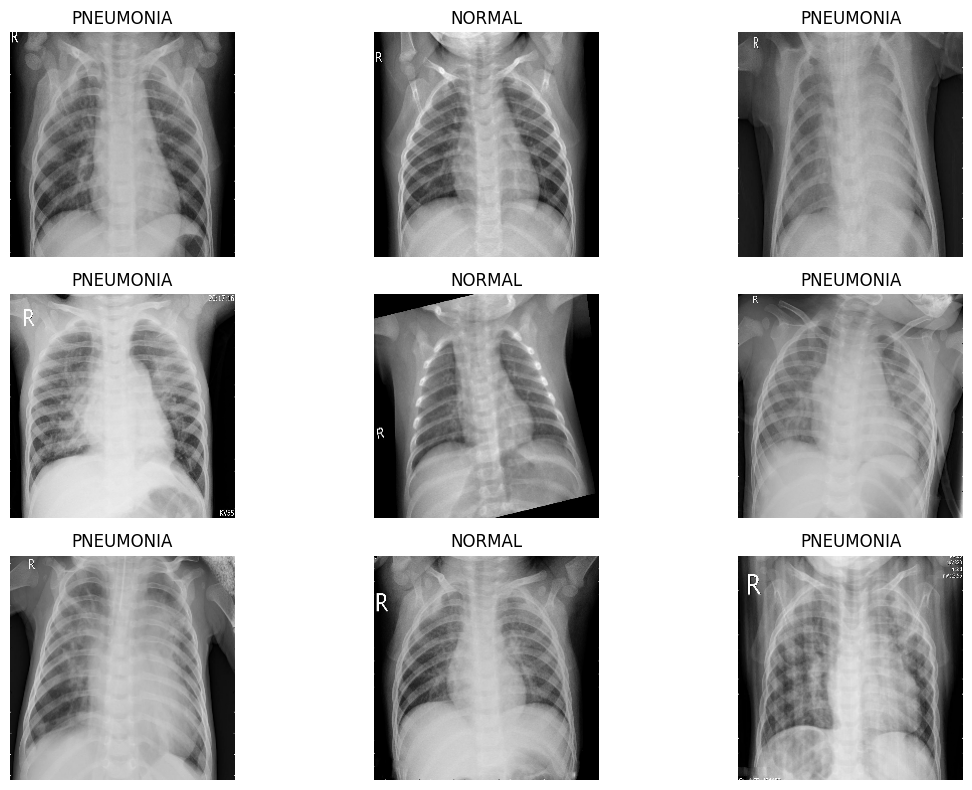

In [33]:
# 📸 Visualisation d’un batch d’images
class_names = train_ds.class_names

plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):  # Prendre un seul batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        label = int(labels[i].numpy())
        plt.imshow(img, cmap='gray')
        plt.title(class_names[label])
        plt.axis("off")
        print(f"Image {i+1} - Shape: {img.shape}")
plt.tight_layout()
plt.show()

## ⚙️ Prétraitement des données : Normalisation et optimisation du pipeline

### 🔄 Normalisation

Les images sont composées de pixels dont les valeurs vont de 0 à 255. Pour faciliter l’apprentissage du modèle, on applique une **normalisation** à l’aide de la couche `Rescaling(1./255)`, ce qui ramène les valeurs des pixels entre 0 et 1.

Cela permet :
- Une **meilleure stabilité numérique** pendant l'entraînement.
- Un **apprentissage plus rapide et efficace** du modèle.

La normalisation est appliquée à chaque dataset (`train_ds`, `val_ds`, `test_ds`) via la méthode `.map()`.

### 🚀 Optimisation du pipeline de données

Pour améliorer les performances lors de l'entraînement, on optimise le pipeline de chargement d’images avec les techniques suivantes :

- `cache()` : stocke les données en mémoire après leur premier chargement.
- `shuffle(1000)` : mélange aléatoirement les données d’entraînement pour éviter les effets de séquence.
- `prefetch(buffer_size=AUTOTUNE)` : permet de précharger les batches suivants pendant que le modèle s'entraîne sur le batch actuel.

Ces optimisations permettent de **maximiser l'utilisation du GPU** ou du CPU pendant l'entraînement et donc de **réduire considérablement le temps total** d'apprentissage.

In [34]:
# Normalisation
normalization_layer = layers.Rescaling(1./255)

# Pipeline avec normalisation
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Améliorer la performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 🧠 Construction du modèle CNN

Nous construisons ici un modèle de réseau de neurones convolutif (**CNN**) simple mais efficace à l’aide de `tf.keras.Sequential`.

### 🧱 Architecture du modèle :

1. **`InputLayer`** : définit la forme d’entrée `(224, 224, 1)` (images en niveaux de gris).
2. **Bloc Convolution + MaxPooling** :
   - `Conv2D(32, (3,3), activation='relu')` : extrait des motifs simples (bords, textures).
   - `MaxPooling2D()` : réduit la dimension spatiale.
3. **Deux autres blocs Conv+Pool** avec 64 puis 128 filtres pour extraire des caractéristiques plus complexes.
4. **Flatten** : mise à plat des cartes de caractéristiques.
5. **Dense(64, activation='relu')** : couche entièrement connectée.
6. **Dropout(0.5)** : régularisation pour éviter l’overfitting.
7. **Dense(1, activation='sigmoid')** : sortie binaire pour classer entre `NORMAL` et `PNEUMONIA`.

### 🔍 Résumé du modèle

La commande `model.summary()` affiche la structure du réseau, le nombre de paramètres par couche, et les dimensions de sortie. Cela permet de vérifier que l’architecture est bien construite avant de passer à l'entraînement.

In [35]:
model = models.Sequential([
    layers.InputLayer(shape=img_size + (1,)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,630,593 (21.48 MB)

 Trainable params: 5,630,593 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

## ⚙️ Compilation du modèle

Avant l’entraînement, le modèle doit être compilé. Cette étape permet de définir :

- **L’optimiseur** :  
  `adam` est un optimiseur populaire basé sur la descente de gradient avec adaptation automatique du taux d’apprentissage.

- **La fonction de perte** :  
  `binary_crossentropy` est utilisée ici car il s’agit d’un problème de classification binaire (`NORMAL` vs `PNEUMONIA`).

- **Les métriques d’évaluation** :
  - `accuracy` : taux de bonnes prédictions globales.
  - `auc` : Aire sous la courbe ROC, mesure la capacité à distinguer les classes.
  - `precision` : proportion de vraies PNEUMONIA parmi les prédictions PNEUMONIA.
  - `recall` : capacité à détecter les cas PNEUMONIA réels.

Cette combinaison de métriques permet une évaluation complète du modèle, surtout dans un contexte médical où **le rappel (recall)** est souvent critique (mieux vaut détecter un faux positif que rater un vrai cas).

In [36]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

## ⏱️ Callbacks : optimisation de l'entraînement

Deux **callbacks** sont utilisés pour rendre l'entraînement plus efficace et éviter l'overfitting :

### 🔽 `ReduceLROnPlateau`
- Surveille la **perte de validation** (`val_loss`).
- Réduit le **learning rate** de moitié (`factor=0.5`) si la performance ne s'améliore pas pendant 2 epochs (`patience=2`).
- Évite de rester bloqué dans un plateau de performance en adaptant dynamiquement la vitesse d’apprentissage.

### 🛑 `EarlyStopping`
- Interrompt l'entraînement si la perte de validation ne s'améliore plus après 4 epochs (`patience=4`).
- Restaure automatiquement les **meilleurs poids** du modèle (`restore_best_weights=True`) pour garantir la meilleure version après entraînement.

Ces deux outils permettent de gagner du temps, d’éviter le surapprentissage et d’obtenir un modèle plus performant.

In [37]:
# Callback pour réduire le learning rate si la validation stagne
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,            
    patience=2,             
    min_lr=1e-6,         
    verbose=1
)

# Callback pour stopper l'entraînement si overfitting détecté
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=4,
    restore_best_weights=True,  
    verbose=1
)

## 🚀 Entraînement du modèle

Le modèle est entraîné sur les données prétraitées pendant **10 epochs**, avec validation à chaque epoch. Deux callbacks sont intégrés pour optimiser l’apprentissage :

- 🔽 `ReduceLROnPlateau` : ajuste dynamiquement le **learning rate** si la perte de validation stagne.
- 🛑 `EarlyStopping` : arrête l’entraînement si aucune amélioration n’est détectée sur la **val_loss** pendant 4 epochs, tout en **restauring les meilleurs poids** du modèle.

In [38]:
# Entraînement du modèle avec les deux callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 124s 748ms/step - accuracy: 0.6823 - auc: 0.7879 - loss: 0.5600 - precision: 0.7290 - recall: 0.5041 - val_accuracy: 0.9371 - val_auc: 0.9805 - val_loss: 0.1877 - val_precision: 0.9150 - val_recall: 0.9638 - learning_rate: 0.0010
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 756ms/step - accuracy: 0.9082 - auc: 0.9691 - loss: 0.2250 - precision: 0.9088 - recall: 0.9069 - val_accuracy: 0.9333 - val_auc: 0.9815 - val_loss: 0.1789 - val_precision: 0.9084 - val_recall: 0.9638 - learning_rate: 0.0010
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 749ms/step - accuracy: 0.9401 - auc: 0.9827 - loss: 0.1653 - precision: 0.9356 - recall: 0.9456 - val_accuracy: 0.9476 - val_auc: 0.9853 - val_loss: 0.1567 - val_precision: 0.9352 - val_recall: 0.9619 - learning_rate: 0.0010
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 737ms/step - accuracy: 0.9552 - auc: 0.9903 - loss: 0.1284 - precision: 0.9609 - recall: 0.9500 - val_accuracy: 0.9495 - val_auc: 0.9903 - val_lo

## 📈 Visualisation des performances d’entraînement

Afin d’analyser l’évolution du modèle au cours des epochs, une fonction `plot_training_history()` est définie. Elle affiche deux courbes :

- 🔹 **Accuracy** (précision) pour l'entraînement et la validation.
- 🔸 **Loss** (erreur) pour l'entraînement et la validation.

Cela permet de détecter d’éventuels phénomènes de surapprentissage (overfitting) ou de sous-apprentissage.

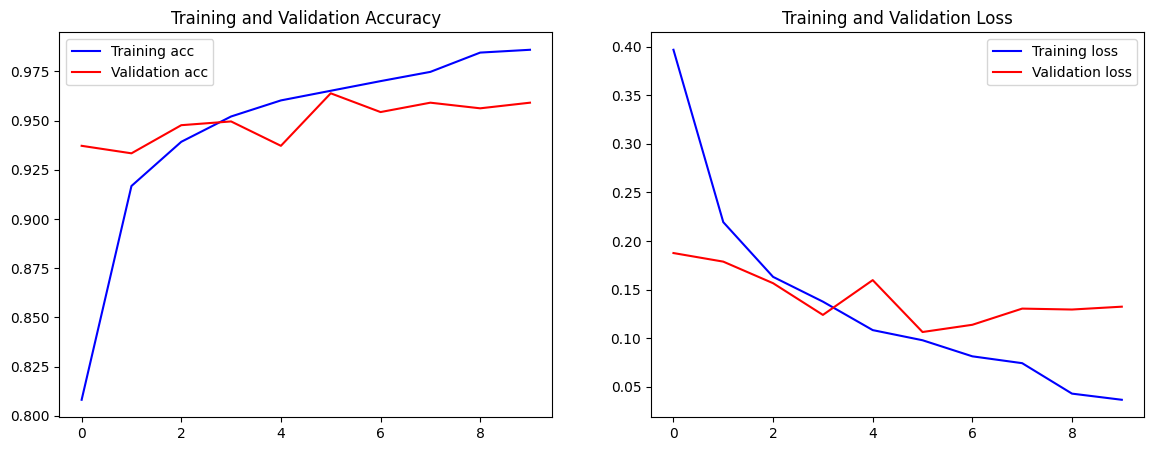

In [39]:
# 🖼️ Affichage courbes accuracy et loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

## 🧪 Évaluation du modèle sur l’ensemble de test

Une fois l’entraînement terminé, on évalue les performances du modèle sur des données jamais vues : le **jeu de test** (`test_ds`).

Le modèle retourne plusieurs métriques clés :

- 🎯 **Accuracy** : proportion globale de bonnes prédictions.
- 📉 **Loss** : erreur moyenne sur les prédictions.
- 📐 **AUC** (*Area Under Curve*) : mesure la capacité du modèle à séparer les classes.
- ✅ **Precision** : proportion de vrais positifs parmi les prédits positifs.
- 🔁 **Recall** : proportion de vrais positifs détectés parmi tous les positifs réels.

In [40]:
# 📊 Évaluation
test_loss, test_acc, test_auc, test_precesion, test_recall = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precesion:.4f}")
print(f"Test Recall: {test_recall:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9530 - auc: 0.9911 - loss: 0.1238 - precision: 0.9552 - recall: 0.9510
Test Accuracy: 0.9629
Test Loss: 0.1094
Test AUC: 0.9922
Test Precision: 0.9655
Test Recall: 0.9600


## 📋 Rapport de classification sur le jeu de test

Pour mieux comprendre la performance du modèle, on génère un **rapport de classification** à partir des vraies étiquettes (`y_true`) et des prédictions binaires (`y_pred`).

- Les probabilités de prédiction sont converties en classes (seuil à 0.5).
- Le rapport fournit des métriques détaillées par classe : 
  - **Precision** (précision)
  - **Recall** (rappel)
  - **F1-score** (moyenne harmonique précision/rappel)
  - **Support** (nombre d’échantillons par classe)

In [41]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype("int32")

print(classification_report(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       525
           1       0.97      0.96      0.96       525

    accuracy                           0.96      1050
   macro avg       0.96      0.96      0.96      1050
weighted avg       0.96      0.96      0.96      1050



## 🔍 Matrice de confusion

La matrice de confusion permet de visualiser la performance du modèle en montrant le nombre de prédictions correctes et incorrectes pour chaque classe.

- Elle affiche les vraies classes en lignes et les prédictions en colonnes.
- Cela aide à comprendre les erreurs spécifiques faites par le modèle (faux positifs, faux négatifs).

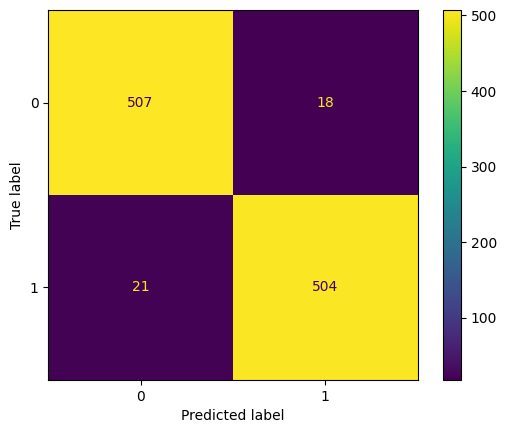

In [42]:
# Matric de confusion

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## 📈 Courbe ROC (Receiver Operating Characteristic)

La courbe ROC est un outil graphique utilisé pour évaluer la performance d'un classificateur binaire à différents seuils de décision.

### Étapes clés :
1. **Extraction des vraies étiquettes** (`y_true`) et des probabilités prédites par le modèle (`y_pred_probs`).
2. **Calcul des points de la courbe ROC** : taux de faux positifs (FPR) et taux de vrais positifs (TPR).
3. **Calcul de l’aire sous la courbe (AUC)**, une métrique qui résume la capacité du modèle à distinguer les classes.
4. **Affichage de la courbe ROC** avec une diagonale représentant un classificateur aléatoire.

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step


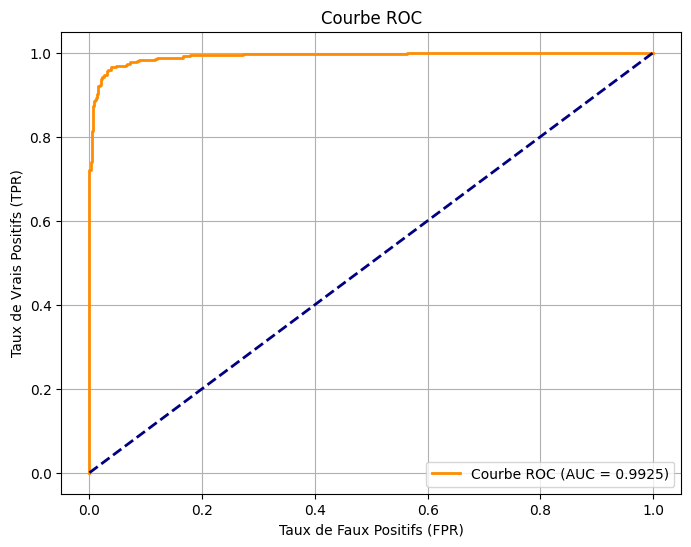

In [43]:
# Étape 1 & 2 : Vraies étiquettes + probabilités prédites
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds).flatten()

# Étape 3 : Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Étape 4 : Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()